# Deep Q-learning (Version 2)
### 2022/06/05, AJ Zerouali


## 1 - Introduction

A modification of the previous implementation of DQN. 

### Fundamental imports

What we're importing and why. Specific references to sections.

In [1]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gym


In [3]:
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import tensorflow as tf
from tensorflow import keras

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _TENSORSHAPEPROTO_

## 2 - DQN with target net




### a) Replay buffer

Doesn't change.


In [5]:
class Replay_Buffer():
    """
        Replay Buffer class for DQN Agent. Instantiated as an attribute of DQN_Agent class.
        Manages the transitions arrays, has one method to store the transitions,
        one method to sample a minibatch of transitions.
        Attributes: 
            mem_size: Maximal size of memory (no. of (s,a,s',r) transitions); 
            mem_cntr: No. of transitions added.
            Self explanatory (np.arrays):
            memory_states, memory_actions, memory_next_states, memory_rewards, memory_terminal
        Methods:
            store_transitions
            sample_buffer
            
    """
    def __init__(self, max_size, input_dims, discrete_actions=True):
        """
            
        INPUT: - max_size: int for max no. of transition samples
               - input_dims: int for array shape of observations
               - discrete_actions: Bool descibing action space
        
        """
        
        # Memory size and counter
        self.mem_size = max_size
        self.mem_cntr = 0
        
        # Discrete actions boolean
        self.discrete_actions = discrete_actions
                
        # Transition arrays for (s,a,s',r)
        self.memory_states = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.memory_actions = np.zeros(self.mem_size, \
                            dtype = np.int8 if self.discrete_actions else np.float32 )
        self.memory_next_states = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.memory_rewards = np.zeros(self.mem_size, dtype = np.float32)
        # If memory_next_states[t] is TERMINAL, will set memory_terminal[t]= 1, and 0 otherwise.
        # Note: Different from Tabor's implementation.
        self.memory_terminal = np.zeros(self.mem_size, dtype = np.int8)
        
    def store_transition(self, state, action, new_state, reward, done):
        """
         Method for storing transitions (s, a, s', r) in the Replay_Buffer.
         INPUT: state, action, new_state, reward = (s, a, s', r)
                done: Boolean for s' terminal
         NOTE: Using tricks from P. Tabor's implementation
        """
        # Current transition index, over-write from first position when memory is full
        ind = self.mem_cntr % self.mem_size
        
        # Add new transition
        self.memory_states[ind] = state
        self.memory_actions[ind] = action
        self.memory_next_states[ind] = new_state
        self.memory_rewards[ind] = reward
        self.memory_terminal[ind] = int(done) # P. Tabor uses (1-int(done)) here
                                                # WARNING: Might be multiplying by this number somewhere
        
        # Update counter
        self.mem_cntr += 1
        
    def sample_buffer(self, batch_size):
        """
        Method for random sampling of a memory minibatch
        INPUT: batch_size
        OUTPUT: sample_state, sample_action, sample_new_state, sample_reward, sample_terminal
                NumPy arrays of transitions of size specified by input
        """
        
        # Choose random indices 
        max_mem = min(self.mem_size, self.mem_cntr)
        batch_indices = np.random.choice(max_mem, batch_size, replace=False)
        
        # Get random minibatch
        sample_state = self.memory_states[batch_indices]
        sample_action = self.memory_actions[batch_indices]
        sample_new_state = self.memory_next_states[batch_indices]
        sample_reward = self.memory_rewards[batch_indices]
        sample_terminal = self.memory_terminal[batch_indices]
        
        return sample_state, sample_action, sample_new_state, sample_reward, sample_terminal


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### c) DQN Agent 


In [1]:
class DQN_Agent():
    """
        Deep Q-network agent class.
        Attributes:
            * RL hyperparameters: learn_rate, gamma, batch_size
                epsilon-greedy policy: epsilon, epsilon_dec, epsilon_min
            * Memory buffer: mem_size, memory_buffer
            * State/action space: input_dims, action_space, discrete_actions
            * Deep network: q_network, dqn_fname
        
        Methods:
            * Constructor
            * Memory management: store_transition
            * Environment interaction: choose_action
            * Deep network management: build_DQN, train_dqn, save_dqn, load_dqn
    """
    
    # Constructor
                # Environment dimensions and action space params
    def __init__(self, input_dims, discrete_actions, n_actions,  \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, batch_size, mem_size = 1000000, \
                 # Decrement and lower bound for eps-greedy
                 epsilon_dec = 1e-3, epsilon_min =0.01, \
                 # Filename model for saving
                 dqn_fname = 'dqn_model.h5'):
        
        """
            INPUT: learn_rate, gamma, epsilon, batch_size, mem_size: Usual deep RL hyperparam
                   input_dims: Shape of states as arrays
                   n_actions: Size of the environment action space. See notes.
                   epsilon_dec, epsilon_min: Decrement of epsilon for policy, end value of epsilon.
            NOTES: 1) For a finite action space set n_actions = env.unwrapped.action_space.n as input.
                      (i.e. size of the finite action space).
                      For continuous action space take dimensionality and bounds of the "Box" object:
                      n_actions = (env.action_space.high, env.action_space.low, env.action_space.shape).
                   2) The agent uses an epsilon-greedy policy for training, with epsilon decreasing by
                      epsion_dec at each step and down to epsilon_min.
                      (Tabor starts with epsilon = 1.0)
            
        """
        # Build agent's action space
        self.discrete_actions = discrete_actions
        if self.discrete_actions:
            self.action_space = [i for i in range(n_actions)]
        else:
            self.action_space = n_actions
            
        # State space dimensionality
        self.input_dims = input_dims
        
        # Deep RL hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_dec = epsilon_dec
        self.batch_size = batch_size
        self.learn_rate = learn_rate
        
        # Init. eval and target DQNs (build model with method below)
        self.q_network = self.build_DQN()
        self.q_target = self.build_DQN()
        self.dqn_fname =  dqn_fname
        
        # Replay buffer. Signature: Replay_Buffer(max_size, input_dims, discrete_actions)
        self.mem_size = mem_size
        self.memory_buffer = Replay_Buffer(self.mem_size, self.input_dims, self.discrete_actions)
        
    # END DEF __init__()
    
    #############################
    ## Environment interaction ##
    #############################
    
    # Choose action following epsilon-greedy policy
    # NOTE: Implemented for discrete action space ONLY
    def choose_action(self, observation):
        """
            Method choosing action in input state following epsilon-greedy policy.
            INPUT: observation (current state)
            OUTPUT: action
        """
        if np.random.uniform(0,1) < self.epsilon:
            action = np.random.choice(self.action_space) # MODIFY FOR CONTINUOUS ACTIONS
        else:
            state = np.array([observation])
            actions = self.q_network.predict(state)
            action = np.argmax(actions)
        
        return action
    # END DEF choose_action()
    
    # Sample transition storage
    def store_transition(self, state, action, new_state, reward, done):
        """
            Method to store a new (s, a, s', r, s'-terminal) transition.
            Calls method of same name from Replay_Buffer class.
        """
        self.memory_buffer.store_transition(state, action, new_state, reward, done)
    
    # END DEF store_transitions()
    
    ##########################
    ## Q-network management ##
    ##########################
    
    # Build Q-network
    def build_DQN(self, fc1_dims=256, fc2_dims=256):
        """
            Builds the DQN. 
            Will use a simple architecture here: 2 fully connected layers; each entry having 256 neurons.
            The loss function is the mean-squared error, the optimizer is Adam.
            Outputs the DQN (keras.models.Sequential() object)
            NOTE: - I will only write this function for the discrete action space for now.
                  - Will have to revise for continuous actions.
                  - I see why Tabor implemented it outside the class.
        """
        # Build normal initializers
        initializer_fc = keras.initializers.RandomNormal(mean = 0.0, stddev=1)
        
        # Build DQN with randomly initialized weights
        dqn = keras.models.Sequential()
        dqn.add(keras.layers.Dense(units = fc1_dims, activation = "relu"))
        dqn.add(keras.layers.Dense(units = fc2_dims, activation = "relu"))
        dqn.add(keras.layers.Dense(units = len(self.action_space)))
        dqn.compile(optimizer = keras.optimizers.Adam(learning_rate=self.learn_rate),\
                   loss = "mse")
        return dqn

    # END DEF Build_DQN()
    
    # Train q_network
    def train_dqn(self, N_steps=0, ep_i=0, notify_end_train=False):
        """
            Method to train the agent's neural net, implements (deep) Q-learning with 1 target network.
            Will check if the memory buffer has at least self.batch_size sample transitions before
            performing training, will do nothing and return False otherwise.
            Can optionally notify when exiting train_on_batch() at every 10 steps of an episode.
            
            ARGUMENTS: - N_steps: Current step -1.
                       - ep_i: Current episode -1
                       - notify_end_train: Boolean for notifications
            
            NOTE: Should write detailed notes about this part.
                  Implemented for DISCRETE ACTIONS ONLY. To be modified.
            
        """
        if self.memory_buffer.mem_cntr < self.batch_size:
            #print("ERROR: Not enough samples (memory_buffer.mem_cntr < batch_size)") # DEBUG
            return False
        else:
            
            # Get minibatch of samples
            # Signature: sample_state, sample_action, sample_new_state, sample_reward, sample_terminal
            #            = Replay_Buffer.sample_buffer(batch_size)
            states, actions, next_states, rewards, dones = self.memory_buffer.sample_buffer(self.batch_size)
            
            # Init. Q(s,a), Q(s', a'), Q*(s,a) 
            q_eval = self.q_network.predict(states) # 
            q_target_next = self.q_target.predict(next_states) # Compute Q^_tgt(s'_j,-;w_)
            q_target = np.copy(q_eval) # Initialize batch y_j's. NOTE: A little confused here
            
            
            # Ones vector for "dones"
            done_ones = np.ones(shape = dones.shape, dtype=np.int8)
            
            # Iterable for minibatch
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            
            # Compute target values in minibatch (y_j = r_j + gamma*max_a Q^_tgt(s'_j,a;w_) )
            # Note: This only updates the values Q^_tgt(s_j,a_j;w_), not the vectors Q^_tgt(s_j,-;w_).
            q_target[batch_index, actions] = rewards + self.gamma*np.max(q_target_next, axis = 1)*(done_ones - dones)
            
            # Train evaluation network: Perform SGD on L(w;w_,{s_j}) = sum_j (y_j - Q^(s_j,a_j;w))^2
            # 
            self.q_network.train_on_batch(states, q_target)
            
            #DEBUG: CHANGE THIS TO NOT KILL MEMORY
            if ((N_steps+1)% 100)==0 and notify_end_train:
                print(f"Done training at step {N_steps+1} of episode {ep_i+1}")
            
            # Update epsilon for policy
            if self.epsilon_min < self.epsilon:
                self.epsilon -= self.epsilon_dec
            else:
                self.epsilon = self.epsilon_min
            
            return True
    
    # END DEF train_dqn()
    
    # Update target network weights
    def update_trgt_wts(self):
        self.q_target.set_weights(self.q_network.get_weights())
    
    # END DEF update_trgt_wts()
    
    ###################
    ## Save/Load DQN ##
    ###################
    
    # Save trained model
    def save_dqn(self):
        """
            Save q_network under dqn_fname (h5 file).
            Calls keras.models.Sequential.save()
        """
        self.q_network.save(self.dqn_fname)
    # END DEF save_dqn()
    
    # Load model
    def load_dqn(self, model_fname):
        """
            Load q_network at model_fname (h5 file).
            Calls keras.models.load_model()
        """
        self.q_network = keras.models.load_model(model_fname)
        
    # END DEF load_dqn()    
    
# END CLASS DQN_Agent

### c) The main

In [7]:
########################################
## IMPORTANT: Add this cell to "main" ##
########################################

# This is to time the execution
from datetime import datetime

Done training at step 70 of episode 1
Done training at step 80 of episode 1
Done training at step 10 of episode 2
Done training at step 20 of episode 2
Done training at step 30 of episode 2
Done training at step 40 of episode 2
Done training at step 50 of episode 2
Done training at step 60 of episode 2
Done training at step 10 of episode 3
Done training at step 20 of episode 3
Done training at step 30 of episode 3
Done training at step 40 of episode 3
Done training at step 50 of episode 3
Done training at step 60 of episode 3
Done training at step 70 of episode 3
Done training at step 80 of episode 3
Done training at step 90 of episode 3
Done training at step 100 of episode 3
Done training at step 110 of episode 3
Done training at step 10 of episode 4
Done training at step 20 of episode 4
Done training at step 30 of episode 4
Done training at step 40 of episode 4
Done training at step 50 of episode 4
Done training at step 60 of episode 4
Done training at step 10 of episode 5
Done train

Done training at step 10 of episode 26
Done training at step 20 of episode 26
Done training at step 30 of episode 26
Done training at step 40 of episode 26
Done training at step 50 of episode 26
Done training at step 60 of episode 26
Done training at step 70 of episode 26
Done training at step 10 of episode 27
Done training at step 20 of episode 27
Done training at step 30 of episode 27
Done training at step 40 of episode 27
Done training at step 50 of episode 27
Done training at step 60 of episode 27
Done training at step 70 of episode 27
Done training at step 80 of episode 27
Done training at step 90 of episode 27
Done training at step 100 of episode 27
Done training at step 10 of episode 28
Done training at step 20 of episode 28
Done training at step 30 of episode 28
Done training at step 40 of episode 28
Done training at step 50 of episode 28
Done training at step 60 of episode 28
Done training at step 70 of episode 28
Done training at step 80 of episode 28
Done training at step 90

Done training at step 80 of episode 47
Done training at step 90 of episode 47
Done training at step 100 of episode 47
Done training at step 110 of episode 47
Done training at step 10 of episode 48
Done training at step 20 of episode 48
Done training at step 30 of episode 48
Done training at step 40 of episode 48
Done training at step 50 of episode 48
Done training at step 60 of episode 48
Done training at step 70 of episode 48
Done training at step 80 of episode 48
Done training at step 90 of episode 48
Done training at step 100 of episode 48
Done training at step 110 of episode 48
Done training at step 10 of episode 49
Done training at step 20 of episode 49
Done training at step 30 of episode 49
Done training at step 40 of episode 49
Done training at step 50 of episode 49
Done training at step 60 of episode 49
Done training at step 70 of episode 49
Done training at step 10 of episode 50
Done training at step 20 of episode 50
Done training at step 30 of episode 50
Done training at step

MovieWriter ffmpeg unavailable; using Pillow instead.


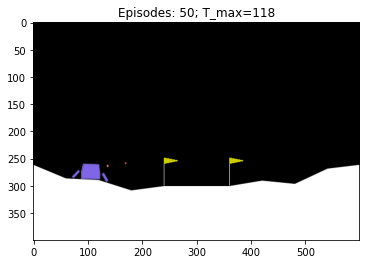

In [23]:
# Disable eager execution (NOTES)
tf.compat.v1.disable_eager_execution

# Create environment
env = gym.make('LunarLander-v2')

# Max no. of episodes and steps:
#n_games = 500
n_games = 50
N_steps_max = 200
N_steps_update = 10

# Deep RL hyperparameters:
learn_rate = 0.001
gamma = 0.99
eps_ini = 1.0
eps_dec = 5e-5
eps_min = 0.01
batch_size = 64
mem_size = 100000
model_file_name = 'dqn_target_1_50Ep_200Stps.h5'

# Ini filenames 
# Visualization: gif filename
rec_gif_fname = "LunarLander_test.gif"
# Total scores
scores_fname = "LunarLander_Scores.csv"
# Epsilon
epsilon_hist_fname = "LunarLander_Epsilon.csv"


# Create agent
"""
class DQN_Agent():

    
    # Constructor
                # Environment dimensions and action space params
    def __init__(self, input_dims, discrete_actions, n_actions,  \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, batch_size, mem_size = 1000000, \
                 # Decrement and lower bound for eps-greedy
                 epsion_dec = 1e-3, epsilon_min =0.01, \
                 # Filename model for saving
                 dqn_fname = 'dqn_model.h5'):    
"""
agent = DQN_Agent(input_dims = env.observation_space.shape, discrete_actions= True, n_actions = env.action_space.n,\
                 learn_rate = learn_rate, gamma=gamma, epsilon=eps_ini, batch_size = batch_size, mem_size = mem_size, \
                 epsilon_dec =eps_dec, epsilon_min =eps_min, dqn_fname = model_file_name)

# Init. score and episode (epsilon) histories
scores_hist = []
eps_hist = []

# Build the DQN (Forgot this on 1st exec...)
# agent.build_DQN(256, 256) # This is done in the constructor now

# Init. fig. 
fig, ax = plt.subplots()
ims = []
# Init. timer of main loop
dqn_begin_time = datetime.now()

# Loop over episodes:
for i in range(n_games):
    
    # Init. episode
    done = False
    score = 0.0
    s = env.reset()
    # DEBUG: Fix no. of max steps
    N_steps = 0
    # Add a first frame
    img= ax.imshow(env.render('rgb_array'), animated = True)
    ims.append([img])
    
    # Loop over steps in episodes
    while not done and (N_steps < N_steps_max):
        
        # Choose an action
        a = agent.choose_action(s)
        # Get reward and next state
        s_, r, done, info = env.step(a)
        # Update score
        score += r
        # Store transition
        agent.store_transition(s, a, s_, r, done)
        
        # Add frame to ims. Should modify later to keep less frames
        ax.set_title(f"Episodes: {i+1}; T_max={N_steps+1}")
        img= ax.imshow(env.render('rgb_array'), animated = True)
        ims.append([img])
        
        # Learn
        agent.train_dqn(N_steps, i, notify_end_train=True)
        # Update state
        s = s_
        # DEBUG: Increment N_steps
        N_steps += 1
        # Update target net weights
        if (N_steps >= batch_size) and ((N_steps%N_steps_update) == 0):
            agent.update_trgt_wts()
        
    # END while over episode steps
    
    # Update epsilon and score histories
    eps_hist.append(agent.epsilon)
    scores_hist.append(score)

# END OF MAIN DQN LOOP (i over episodes) 

# Exec time of main loop
dqn_exec_time = datetime.now()-dqn_begin_time

# Stop the recording, time the compilation of gif file
dqn_begin_time = datetime.now()
rec = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
env.close()
rec.save(rec_gif_fname)
rec_exec_time = datetime.now()-dqn_begin_time

# Save total scores and epsilon decrease
### NOTE: Modify the code below to clean-out output
df_scores = pd.DataFrame(scores_hist, columns = ['Tot. Score'])
df_scores.to_csv(scores_fname)
# Compute mean, min and max of scores, added to report below.
scores_mean = df_scores["Tot. Score"].mean()
scores_max = df_scores["Tot. Score"].max()
scores_min = df_scores["Tot. Score"].min()
df_epsilon = pd.DataFrame(eps_hist, columns = ['Epsilon'])
df_epsilon.to_csv(epsilon_hist_fname)

# Save trained DQN model:
agent.save_dqn()

# Report file open
dqn_begin_time = datetime.now()
report_fname = "Report_LunLand_DQN_"\
                +str(dqn_begin_time.year-2000)+str(dqn_begin_time.month)+str(dqn_begin_time.day)\
                +str(dqn_begin_time.hour)+str(dqn_begin_time.minute)+".txt"
report_file = open(report_fname, mode = "w+")
# Title
report_file.write(f"Deep Q-learning agent - {dqn_begin_time}:\n")
# Write report to file
report_file.write(f"- Execution over {n_games} episodes with {N_steps_max} max. steps completed.\n")
report_file.write(f"- Total training time: {dqn_exec_time}.\n")
report_file.write(f"- Average score over {n_games} episodes: {scores_mean}.\n")
report_file.write(f"- Highest score: {scores_max}.\n")
report_file.write(f"- Lowest score: {scores_min}.\n")
report_file.write(f"- GIF recording compilation time: {rec_exec_time} (name: {rec_gif_fname}).\n")
report_file.write(f"- DRL Hypeparameters: * learn_rate = {learn_rate},\n")
report_file.write(f"                      * gamma = {gamma},\n")
report_file.write(f"                      * eps_ini = {eps_ini},\n")
report_file.write(f"                      * eps_dec = {eps_dec},\n")
report_file.write(f"                      * eps_min = {eps_min},\n")
report_file.write(f"                      * batch_size = {batch_size},\n")
report_file.write(f"                      * mem_size = {mem_size},\n")
report_file.write(f"                      * Saved model filename = {model_file_name}.\n")
# Close report file
report_file.close()



In [16]:
N_steps

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10

In [17]:
env.close()

In [18]:
i

0

#### Long test 22/05/16 - Training scores
The test that took 5 hours (500 episodes with 2000 max steps). Want to look at scores during training

In [9]:
test_scores_hist = pd.read_csv("LunarLander_Scores_225162122.csv")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

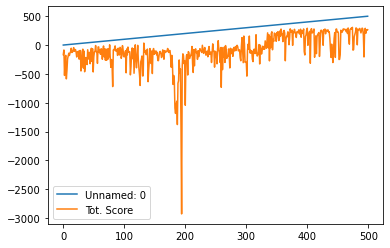

In [10]:
test_scores_hist.plot()

In [11]:
test_scores_hist["Tot. Score"].mean()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-85.87229213010052

In [12]:
test_scores_hist["Tot. Score"].max()

306.54625316026693

In [13]:
test_scores_hist["Tot. Score"].min()

-2925.983399796788

In [14]:
type(test_scores_hist["Tot. Score"])

pandas.core.series.Series